In [1]:
import os
from pathlib import Path

import pandas as pd
import polars as pl
from matplotlib import pyplot as plt
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch import argmax, concat, set_float32_matmul_precision, stack
from torch.utils.data import DataLoader

from mirror.dataloaders.loader import DataModule
from mirror.encoders import TableEncoder, YXDataset, YZDataset, ZDataset
from mirror.encoders.maps import rename
from mirror.models.cvae import CVAE
from mirror.models.cvae_components import (
    CVAEDecoderBlock,
    CVAEEncoderBlock,
    LabelsEncoderBlock,
)

In [2]:
LOGDIR = Path("demo_logs")

In [3]:
census = pl.read_csv("data/census.csv")
census = census.rename(rename)

# drop resident_id_m column
census = census.drop("pid")
print(len(census))

uniques = census.unique()
p = len(uniques) / len(census)
print(f"Probability of unique person = {p:.3}")

census.describe()

604351
Probability of unique person = 0.616


statistic,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,str,f64,f64,f64,f64,f64
"""count""",604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,604351.0,"""604351""",604351.0,604351.0,"""604351""",604351.0,604351.0,604351.0,604351.0,604351.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",0.178228,1.063016,1.033194,3.497759,1.647728,2.218036,-3.070486,1.264133,2.121696,null,0.153633,1.086539,null,2.323451,1.018094,4.013229,1.489475,1.016006
"""std""",4.390827,1.048737,4.964835,1.565592,1.379937,1.718835,5.364332,2.233842,6.579392,null,4.008883,6.134046,null,2.434336,0.133291,2.128897,0.49989,0.142094
"""min""",-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,-8.0,"""-8""",-8.0,-8.0,"""E12000001""",-8.0,1.0,1.0,1.0,1.0
"""25%""",1.0,1.0,1.0,4.0,1.0,2.0,-8.0,1.0,-8.0,null,1.0,-8.0,null,1.0,1.0,2.0,1.0,1.0
"""50%""",2.0,1.0,1.0,4.0,2.0,2.0,-8.0,2.0,5.0,null,1.0,3.0,null,2.0,1.0,4.0,1.0,1.0
"""75%""",3.0,1.0,5.0,4.0,2.0,3.0,3.0,2.0,8.0,null,2.0,6.0,null,2.0,1.0,6.0,2.0,1.0
"""max""",4.0,2.0,9.0,5.0,5.0,5.0,4.0,2.0,9.0,"""E13000002""",5.0,9.0,"""W92000004""",9.0,2.0,7.0,2.0,3.0


In [4]:
census.head()

social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64,i64,i64,i64
4,1,1,4,1,4,4,2,4,"""-8""",1,5,"""E12000003""",2,1,4,2,1
-8,1,5,4,2,1,-8,2,7,"""-8""",1,2,"""E12000005""",2,1,7,2,1
-8,2,5,4,2,1,-8,2,7,"""-8""",1,3,"""E12000002""",2,1,7,2,1
-8,1,5,4,3,2,-8,2,8,"""-8""",2,8,"""E12000006""",2,1,7,1,1
4,1,8,4,2,1,-8,2,9,"""-8""",1,9,"""E12000002""",1,1,2,2,1


In [5]:
# Define controls aka labels aka Y, that will be used to condition generation
controls = ["sex", "age_group", "region"]
census_controls = census[controls]
target_census = census.drop(controls)

controls_encoder = TableEncoder(census_controls, verbose=True)
y_dataset = controls_encoder.encode(data=census_controls)
controls_encoder.names()

CategoricalTokeniser: size: 2, categories: {1: 0, 2: 1}, dtype: Int64
CategoricalTokeniser: size: 7, categories: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}, dtype: Int64
CategoricalTokeniser: size: 10, categories: {'E12000001': 0, 'E12000002': 1, 'E12000003': 2, 'E12000004': 3, 'E12000005': 4, 'E12000006': 5, 'E12000007': 6, 'E12000008': 7, 'E12000009': 8, 'W92000004': 9}, dtype: String
<mirror.encoders.table_encoder.TableEncoder object at 0x71fcfae8bb30> encoded -> <mirror.encoders.table_encoder.CensusDataset object at 0x71fbdf1f74a0>: torch.Size([604351, 3])


/home/fred/Projects/mirror/src/mirror/encoders/utils.py:36: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  encoded = Tensor(encoded.to_numpy()).int()


['sex', 'age_group', 'region']

In [6]:
# Define census aka X, that will be generated
census_encoder = TableEncoder(target_census, verbose=True)
x_dataset = census_encoder.encode(data=target_census)
census_encoder.names()

CategoricalTokeniser: size: 5, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4}, dtype: Int64
CategoricalTokeniser: size: 3, categories: {-8: 0, 1: 1, 2: 2}, dtype: Int64
CategoricalTokeniser: size: 10, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}, dtype: Int64
CategoricalTokeniser: size: 6, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, dtype: Int64
CategoricalTokeniser: size: 6, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, dtype: Int64
CategoricalTokeniser: size: 6, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}, dtype: Int64
CategoricalTokeniser: size: 5, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4}, dtype: Int64
CategoricalTokeniser: size: 3, categories: {-8: 0, 1: 1, 2: 2}, dtype: Int64
CategoricalTokeniser: size: 10, categories: {-8: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}, dtype: Int64
CategoricalTokeniser: size: 3, categories: {'-8': 0, 'E13000001': 1, 'E13000002': 2}, dtype: String
CategoricalTokeniser: size: 6, categories: 

['social',
 'country_of_birth',
 'employment_status',
 'ethnicity',
 'health',
 'household_type',
 'hours_worked',
 'full_time_student',
 'industry',
 'inner/outer_london',
 'marital_status',
 'occupaion',
 'religion',
 'residence_type',
 'residency_type']

In [7]:
# combine into dataset object
yx_dataset = YXDataset(x_dataset, y_dataset)
dataloader = DataModule(
    dataset=yx_dataset,
    val_split=0.1,
    test_split=0.1,
    train_batch_size=512,
    val_batch_size=512,
    test_batch_size=512,
    num_workers=4,
    pin_memory=False,
)

In [8]:
latent = 12

# encoder block to embed labels into vec with hidden size
labels_encoder_block = LabelsEncoderBlock(
    encoder_types=controls_encoder.types(),
    encoder_sizes=controls_encoder.sizes(),
    depth=2,
    hidden_size=32,
)

# encoder and decoder block to process census data
encoder = CVAEEncoderBlock(
    encoder_types=census_encoder.types(),
    encoder_sizes=census_encoder.sizes(),
    depth=2,
    hidden_size=32,
    latent_size=latent,
)
decoder = CVAEDecoderBlock(
    encoder_types=census_encoder.types(),
    encoder_sizes=census_encoder.sizes(),
    depth=2,
    hidden_size=32,
    latent_size=latent,
)

# CVAE model
cvae = CVAE(
    embedding_names=census_encoder.names(),
    embedding_types=census_encoder.types(),
    embedding_weights=census_encoder.weights(),
    labels_encoder_block=labels_encoder_block,
    encoder_block=encoder,
    decoder_block=decoder,
    beta=0.1,
    lr=0.001,
)

In [9]:
set_float32_matmul_precision("medium")

LOGDIR.mkdir(parents=True, exist_ok=True)
log_dir = str(Path(LOGDIR))

logger = WandbLogger(project="nomis_demo", dir=log_dir)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, mode="min"),
    ModelCheckpoint(
        monitor="val_loss",
        save_top_k=1,
        mode="min",
        dirpath=Path(log_dir, "checkpoints"),
        save_weights_only=False,
    ),
]
trainer = Trainer(
    min_epochs=1,
    max_epochs=10,
    callbacks=callbacks,
    logger=logger,
    check_val_every_n_epoch=1,
)
trainer.fit(model=cvae, train_dataloaders=dataloader)
# trainer.validate(model=cvae, dataloaders=dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: fredjshone (fredjshone-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/fred/Projects/mirror/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/fred/Projects/mirror/demo_logs/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type               | Params | Mode 
--------------------------------------------------------------------
0 | labels_encoder_block | LabelsEncoderBlock | 2.7 K  | train
1 | encoder_block        | CVAEEncoderBlock   | 5.7 K  | train
2 | decoder_block        | CVAEDecoderBlock   | 4.4 K  | train
3 | criterion            | ModuleList         | 0      | train
--------------------------------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
n = len(yx_dataset)
z_loader = ZDataset(n, latent_size=latent)
yz_loader = YZDataset(z_loader, y_dataset)
gen_loader = DataLoader(
    yz_loader, batch_size=512, num_workers=4, persistent_workers=True
)

ys, xs, zs = zip(*trainer.predict(dataloaders=gen_loader))
ys = concat(ys)
xs = concat([stack([argmax(x, dim=1) for x in xb], dim=-1) for xb in xs], dim=0)
zs = concat(zs)

/home/fred/Projects/mirror/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:149: `.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.predict(ckpt_path='best')` to use the best model or `.predict(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/fred/Projects/mirror/demo_logs/checkpoints/epoch=0-step=945-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/fred/Projects/mirror/demo_logs/checkpoints/epoch=0-step=945-v13.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

In [11]:
controls_df = controls_encoder.decode(ys)
census_df = census_encoder.decode(xs).drop("pid")
df = pl.concat([controls_df, census_df], how="horizontal")
df.head()

pid,sex,age_group,region,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,religion,residence_type,residency_type
i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
0,2,4,"""E12000003""",3,2,2,4,2,3,4,2,4,"""-8""",3,5,3,1,1
1,2,7,"""E12000005""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,5,2,2,1
2,2,7,"""E12000002""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,5,2,2,1
3,1,7,"""E12000006""",-8,1,5,4,4,1,-8,2,8,"""-8""",5,4,2,2,1
4,2,2,"""E12000002""",2,-8,6,-8,-8,-8,1,1,-8,"""-8""",1,-8,-8,2,2


In [12]:
os.makedirs("tmp", exist_ok=True)
path = Path("tmp") / "demo_synthetic.csv"
print(f"Writing synthetic data to {path}")
df.write_csv(path)

Writing synthetic data to tmp/demo_synthetic.csv


In [19]:
path = Path("tmp") / "demo_synthetic.csv"
synthetic = pl.read_csv(path).drop(["pid"])
synthetic.head()

sex,age_group,region,social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,religion,residence_type,residency_type
i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64
2,4,"""E12000003""",3,2,2,4,2,3,4,2,4,"""-8""",3,5,3,1,1
2,7,"""E12000005""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,5,2,2,1
2,7,"""E12000002""",-8,1,5,4,4,1,-8,2,1,"""-8""",5,5,2,2,1
1,7,"""E12000006""",-8,1,5,4,4,1,-8,2,8,"""-8""",5,4,2,2,1
2,2,"""E12000002""",2,-8,6,-8,-8,-8,1,1,-8,"""-8""",1,-8,-8,2,2


In [20]:
from mirror.eval import density

census.head()

social,country_of_birth,employment_status,ethnicity,health,household_type,hours_worked,full_time_student,industry,inner/outer_london,marital_status,occupaion,region,religion,residence_type,age_group,sex,residency_type
i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,str,i64,i64,i64,i64,i64
4,1,1,4,1,4,4,2,4,"""-8""",1,5,"""E12000003""",2,1,4,2,1
-8,1,5,4,2,1,-8,2,7,"""-8""",1,2,"""E12000005""",2,1,7,2,1
-8,2,5,4,2,1,-8,2,7,"""-8""",1,3,"""E12000002""",2,1,7,2,1
-8,1,5,4,3,2,-8,2,8,"""-8""",2,8,"""E12000006""",2,1,7,1,1
4,1,8,4,2,1,-8,2,9,"""-8""",1,9,"""E12000002""",1,1,2,2,1


In [21]:
density.frequencies(census, ["sex"], alias="target")

target,index
u32,str
295815,"""2"""
308536,"""1"""


In [22]:
from mirror.eval.density import iter_joint_probs, calc_mae, calc_cross_entropy

Order 1:
Mean MAE (order 1): 0.1026
Order 2:
Mean MAE (order 1): 0.0462


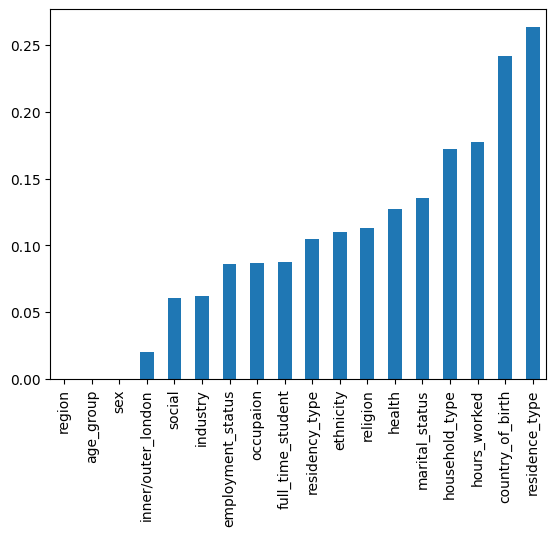

In [31]:
results = {}
for order in [1, 2]:
    print(f"Order {order}:")
    maes = {}
    cross_entropies = {}
    for name, index, x, xhat in iter_joint_probs(
        census, synthetic, order=order
    ):  
        cross_entropy = calc_cross_entropy(x, xhat)
        maes[name] = calc_mae(x, xhat)
    results[order] = maes

    mean_mae = sum(maes.values()) / len(maes)
    print(f"Mean MAE (order 1): {mean_mae:.4f}")

pd.Series(results[1]).sort_values().plot.bar()
plt.show()




In [ ]:
results = {}
for order in range(1, 3):
    print(f"calculating order {order}")
    maes = {}
    for name, index, target, synthetic in compute_joint_frequencies(
        census, df, order=order
    ):
        join = join_probs(target, synthetic)
        maes[name] = calc_mnae(join)
    results[order] = maes

for order, res in results.items():
    print(f"Order {order}: MAE mean = {pd.Series(res).mean():.4f}")
    pd.Series(res).sort_values().plot.bar()
    plt.show()
    print(pd.Series(res).sort_values().tail(1))

In [ ]:
pd.Series(results[1]).sort_values().tail(1)

In [ ]:
census["household_type"].value_counts().join(
    df["household_type"].value_counts(), on="household_type", how="outer"
)

In [ ]:
df["household_type"].value_counts()